# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Project Definition

## Problem Statement

Based on the dataset provided by Starbucks, the aim of this project is to understand better the Starbucks offers, providing more inteligence when sending or not a offer to the customer, and which type of offer.

### Project Deliverables
The specific project deliverables are depicted below:
* Create a data vizualization to understand how much each type of offer affect customers, using customers binned by profile
* Create a machine learning algorithm that tells if a offer will affect the customer or not

### Metrics
For the machine learning algorithm, the accuracy, recall, precision and F1-score will be used to understand how much the trained algorithm can be used to determine if Starbucks should or not send the offer. Additionally, the binomial error will be used to determine the statistical representativity of the results.

# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from tqdm import tqdm
import plotly.express as px
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Assess Data and Clean Data

### Portfolio Dataset

In [2]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [3]:
portfolio.rename(columns={'id': 'offer'}, inplace=True)

In [4]:
for channel in ['email', 'mobile', 'social', 'web']:
    portfolio[channel] = portfolio['channels'].apply(lambda row: 1 if (channel in row) else 0)
# df.columns = ['team_{}'.format(x+1) for x in df.columns]

In [5]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                              offer  email  mobile  social  web  
0  ae264e3637204a6fb9bb56bc8210ddfd      1       1       1    0  
1  4d5c57ea9a6940dd891ad53e9dbe8da0      1       1       1    1  
2  3f207df678b143eea3cee63160fa8bed      1       1       0    1  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      1       1       0    1  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7      1       0       0    1  
5  2298d6c36e964ae4a3e7e9706d1fb8c2      1       1       1    1  
6  fafdcd668e3743c1bb461111dcafc2a4      1       1       1    1  
7  5a8bc65990b245e5a138643cd4eb9837      1       1       1    0  
8  f19421c1d4aa40978ebb69ca19b0e20d      1       1       1    1  
9  2906b810c7d4411798c6938adc9daaa5      1       1       0    1

### Profile Dataset

In [6]:
profile

gender  age                                id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [7]:
# remove persons olders than 100 years and without income
profile = profile[profile['income'].notnull()]
real_persons = profile.id.unique()

In [8]:
profile.rename(columns={'id': 'person'}, inplace=True)
profile

C:\Users\grego\Anaconda3\envs\venture\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


gender  age                            person  became_member_on  \
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
5          M   68  e2127556f4f64592b11af22de27a7932          20180426   
8          M   65  389bc3fa690240e798340f5a15918d5c          20180209   
12         M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
1      112000.0  
3      100000.0  
5       70000.0  
8       53000.0  
12      51000.0  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[14825 rows x 5 columns]

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'became_member_on'}>],
       [<AxesSubplot:title={'center':'income'}>, <AxesSubplot:>]],
      dtype=object)

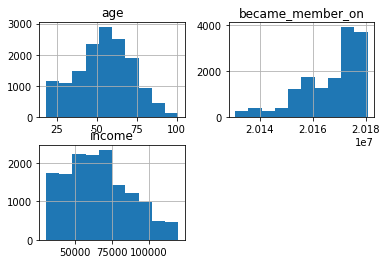

In [9]:
profile.hist()

### Transcript Dataset

In [10]:
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
...                                                  ...   ...  
306529                    {'amount': 1.5899999999999999}   714  
306530                                  {'amount': 9.53}   714  
306531                                  {'amount': 3.61}   714  
306532                    {'amount': 3.5300000000000002}   714  
306533                                  {'amount': 4.05}   714  

[306534 rows x 4 columns]

In [11]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### Merge Datasets

In [12]:
# persons_viewed = transcript[transcript['event'] == 'offer viewed']['person'].unique()
persons_received = transcript[transcript['event'] == 'offer received']['person'].unique()

In [13]:
transcript['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
79d9d4f86aca4bed9290350fb43817c2    48
                                    ..
3a4e53046c544134bb1e7782248631d1     2
afd41b230f924f9ca8f5ed6249616114     2
1bfe13d2453c4185a6486c6817e0d568     2
912b9f623b9e4b4eb99b6dc919f09a93     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: person, Length: 17000, dtype: int64

In [14]:
transcript_offers = transcript[transcript['person'].isin(persons_received)]
transcript_offers = transcript_offers[transcript_offers['person'].isin(real_persons)]

In [15]:
transcript_offers['person'].value_counts()

94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
                                    ..
afd41b230f924f9ca8f5ed6249616114     2
df9fc9a86ca84ef5aedde8925d5838ba     2
22617705eec442e0b7b43e5c5f56fb17     2
e63e42480aae4ede9f07cac49c8c3f78     2
fccc9279ba56411f80ffe8ce7e0935cd     2
Name: person, Length: 14820, dtype: int64

In [16]:
transcript_offers

person            event  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received   
2       e2127556f4f64592b11af22de27a7932   offer received   
5       389bc3fa690240e798340f5a15918d5c   offer received   
7       2eeac8d8feae4a8cad5a6af0499a211d   offer received   
8       aa4862eba776480b8bb9c68455b8c2e1   offer received   
...                                  ...              ...   
306527  24f56b5e1849462093931b164eb803b5  offer completed   
306529  b3a1272bc9904337b331bf348c3e8c17      transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35      transaction   
306531  a00058cf10334a308c68e7631c529907      transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec      transaction   

                                                    value  time  
0        {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
2        {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
5        {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
7        {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8        {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
...                                                   ...   ...  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306529                     {'amount': 1.5899999999999999}   714  
306530                                   {'amount': 9.53}   714  
306531                                   {'amount': 3.61}   714  
306532                     {'amount': 3.5300000000000002}   714  

[272743 rows x 4 columns]

In [17]:
transcript_offers = transcript_offers[(transcript_offers['event'] == 'offer received') | (transcript_offers['event'] == 'offer viewed') | (transcript_offers['event'] == 'offer completed')]

In [18]:
transcript_offers

person            event  \
0       78afa995795e4d85b5d9ceeca43f5fef   offer received   
2       e2127556f4f64592b11af22de27a7932   offer received   
5       389bc3fa690240e798340f5a15918d5c   offer received   
7       2eeac8d8feae4a8cad5a6af0499a211d   offer received   
8       aa4862eba776480b8bb9c68455b8c2e1   offer received   
...                                  ...              ...   
306483  84fb57a7fe8045a8bf6236738ee73a0f     offer viewed   
306490  abc4359eb34e4e2ca2349da2ddf771b6     offer viewed   
306507  8dda575c2a1d44b9ac8e8b07b93d1f8e     offer viewed   
306509  8431c16f8e1d440880db371a68f82dd0  offer completed   
306527  24f56b5e1849462093931b164eb803b5  offer completed   

                                                    value  time  
0        {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
2        {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
5        {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
7        {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8        {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
...                                                   ...   ...  
306483   {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}   714  
306490   {'offer id': '3f207df678b143eea3cee63160fa8bed'}   714  
306507   {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}   714  
306509  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  

[148805 rows x 4 columns]

In [19]:
df_offers = pd.DataFrame(columns=['person', 'offer_received', 'offer_viewed', 'offer_completed', 'offer_id'])

In [20]:
offers_df = pd.DataFrame()
for person in tqdm(real_persons):
    df_aux = transcript_offers[transcript_offers['person'] == person]

    offers = dict()
    for line in range(len(df_aux)):
        if df_aux.iloc[line, df_aux.columns.get_loc('event')] == 'offer received':
            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')].get('offer id')] = dict()
            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')].get('offer id')]['person'] = person

            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')].get('offer id')]['offer received time'] = df_aux.iloc[line, df_aux.columns.get_loc('time')]
        elif df_aux.iloc[line, df_aux.columns.get_loc('event')] == 'offer viewed':
            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')].get('offer id')]['offer viewed time'] = df_aux.iloc[line, df_aux.columns.get_loc('time')]
        else:
            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')]['offer_id']]['offer completed time'] = df_aux.iloc[line, df_aux.columns.get_loc('time')]
            offers[df_aux.iloc[line, df_aux.columns.get_loc('value')]['offer_id']]['reward completed'] = df_aux.iloc[line, df_aux.columns.get_loc('value')]['reward']

    offers_df = offers_df.append(pd.DataFrame(offers).transpose())

100%|██████████| 14825/14825 [07:42<00:00, 32.04it/s]


In [21]:
offers_df['offer'] = offers_df.index
offers_df

person  \
9b98b8c7a33c4b65b9aebfe6a799e6d9  0610b486422d4921ae7d2bf64640c50b   
3f207df678b143eea3cee63160fa8bed  0610b486422d4921ae7d2bf64640c50b   
9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef   
5a8bc65990b245e5a138643cd4eb9837  78afa995795e4d85b5d9ceeca43f5fef   
ae264e3637204a6fb9bb56bc8210ddfd  78afa995795e4d85b5d9ceeca43f5fef   
...                                                            ...   
9b98b8c7a33c4b65b9aebfe6a799e6d9  9dc1421481194dcd9400aec7c9ae6366   
ae264e3637204a6fb9bb56bc8210ddfd  9dc1421481194dcd9400aec7c9ae6366   
2298d6c36e964ae4a3e7e9706d1fb8c2  e4052622e5ba45a8b96b59aba68cf068   
3f207df678b143eea3cee63160fa8bed  e4052622e5ba45a8b96b59aba68cf068   
f19421c1d4aa40978ebb69ca19b0e20d  e4052622e5ba45a8b96b59aba68cf068   

                                 offer received time offer completed time  \
9b98b8c7a33c4b65b9aebfe6a799e6d9                 408                  528   
3f207df678b143eea3cee63160fa8bed                 504                  NaN   
9b98b8c7a33c4b65b9aebfe6a799e6d9                   0                  132   
5a8bc65990b245e5a138643cd4eb9837                 168                  NaN   
ae264e3637204a6fb9bb56bc8210ddfd                 408                  510   
...                                              ...                  ...   
9b98b8c7a33c4b65b9aebfe6a799e6d9                 408                  414   
ae264e3637204a6fb9bb56bc8210ddfd                 576                  594   
2298d6c36e964ae4a3e7e9706d1fb8c2                   0                   54   
3f207df678b143eea3cee63160fa8bed                 576                  NaN   
f19421c1d4aa40978ebb69ca19b0e20d                 408                  480   

                                 reward completed offer viewed time  \
9b98b8c7a33c4b65b9aebfe6a799e6d9                5               NaN   
3f207df678b143eea3cee63160fa8bed              NaN               NaN   
9b98b8c7a33c4b65b9aebfe6a799e6d9                5                 6   
5a8bc65990b245e5a138643cd4eb9837              NaN               216   
ae264e3637204a6fb9bb56bc8210ddfd               10               408   
...                                           ...               ...   
9b98b8c7a33c4b65b9aebfe6a799e6d9                5               516   
ae264e3637204a6fb9bb56bc8210ddfd               10               624   
2298d6c36e964ae4a3e7e9706d1fb8c2                3                 6   
3f207df678b143eea3cee63160fa8bed              NaN               NaN   
f19421c1d4aa40978ebb69ca19b0e20d                5               546   

                                                             offer  
9b98b8c7a33c4b65b9aebfe6a799e6d9  9b98b8c7a33c4b65b9aebfe6a799e6d9  
3f207df678b143eea3cee63160fa8bed  3f207df678b143eea3cee63160fa8bed  
9b98b8c7a33c4b65b9aebfe6a799e6d9  9b98b8c7a33c4b65b9aebfe6a799e6d9  
5a8bc65990b245e5a138643cd4eb9837  5a8bc65990b245e5a138643cd4eb9837  
ae264e3637204a6fb9bb56bc8210ddfd  ae264e3637204a6fb9bb56bc8210ddfd  
...                                                            ...  
9b98b8c7a33c4b65b9aebfe6a799e6d9  9b98b8c7a33c4b65b9aebfe6a799e6d9  
ae264e3637204a6fb9bb56bc8210ddfd  ae264e3637204a6fb9bb56bc8210ddfd  
2298d6c36e964ae4a3e7e9706d1fb8c2  2298d6c36e964ae4a3e7e9706d1fb8c2  
3f207df678b143eea3cee63160fa8bed  3f207df678b143eea3cee63160fa8bed  
f19421c1d4aa40978ebb69ca19b0e20d  f19421c1d4aa40978ebb69ca19b0e20d  

[55222 rows x 6 columns]

In [22]:
offers_profile = pd.merge(offers_df, profile, on=['person'], how='left')

In [23]:
offers_profile_complete = pd.merge(offers_profile, portfolio, on=['offer'], how='left')
offers_profile_complete.drop(['channels'], inplace=True, axis=1)
offers_profile_complete

person offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                 408   
1      0610b486422d4921ae7d2bf64640c50b                 504   
2      78afa995795e4d85b5d9ceeca43f5fef                   0   
3      78afa995795e4d85b5d9ceeca43f5fef                 168   
4      78afa995795e4d85b5d9ceeca43f5fef                 408   
...                                 ...                 ...   
55217  9dc1421481194dcd9400aec7c9ae6366                 408   
55218  9dc1421481194dcd9400aec7c9ae6366                 576   
55219  e4052622e5ba45a8b96b59aba68cf068                   0   
55220  e4052622e5ba45a8b96b59aba68cf068                 576   
55221  e4052622e5ba45a8b96b59aba68cf068                 408   

      offer completed time reward completed offer viewed time  \
0                      528                5               NaN   
1                      NaN              NaN               NaN   
2                      132                5                 6   
3                      NaN              NaN               216   
4                      510               10               408   
...                    ...              ...               ...   
55217                  414                5               516   
55218                  594               10               624   
55219                   54                3                 6   
55220                  NaN              NaN               NaN   
55221                  480                5               546   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  reward  difficulty  duration     offer_type  email  mobile  \
0      112000.0       5           5         7           bogo      1       1   
1      112000.0       0           0         4  informational      1       1   
2      100000.0       5           5         7           bogo      1       1   
3      100000.0       0           0         3  informational      1       1   
4      100000.0      10          10         7           bogo      1       1   
...         ...     ...         ...       ...            ...    ...     ...   
55217   50000.0       5           5         7           bogo      1       1   
55218   50000.0      10          10         7           bogo      1       1   
55219   82000.0       3           7         7       discount      1       1   
55220   82000.0       0           0         4  informational      1       1   
55221   82000.0       5           5         5           bogo      1       1   

       social  web  
0           0    1  
1           0    1  
2           0    1  
3           1    0  
4           1    0  
...       ...  ...  
55217       0    1  
55218       1    0  
55219       1    1  
55220       0    1  
55221       1    1  

[55222 rows x 18 columns]

In [24]:
offers_profile_complete['offer end time'] = offers_profile_complete['offer received time'] + offers_profile_complete['duration']*24
offers_profile_complete

person offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                 408   
1      0610b486422d4921ae7d2bf64640c50b                 504   
2      78afa995795e4d85b5d9ceeca43f5fef                   0   
3      78afa995795e4d85b5d9ceeca43f5fef                 168   
4      78afa995795e4d85b5d9ceeca43f5fef                 408   
...                                 ...                 ...   
55217  9dc1421481194dcd9400aec7c9ae6366                 408   
55218  9dc1421481194dcd9400aec7c9ae6366                 576   
55219  e4052622e5ba45a8b96b59aba68cf068                   0   
55220  e4052622e5ba45a8b96b59aba68cf068                 576   
55221  e4052622e5ba45a8b96b59aba68cf068                 408   

      offer completed time reward completed offer viewed time  \
0                      528                5               NaN   
1                      NaN              NaN               NaN   
2                      132                5                 6   
3                      NaN              NaN               216   
4                      510               10               408   
...                    ...              ...               ...   
55217                  414                5               516   
55218                  594               10               624   
55219                   54                3                 6   
55220                  NaN              NaN               NaN   
55221                  480                5               546   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  reward  difficulty  duration     offer_type  email  mobile  \
0      112000.0       5           5         7           bogo      1       1   
1      112000.0       0           0         4  informational      1       1   
2      100000.0       5           5         7           bogo      1       1   
3      100000.0       0           0         3  informational      1       1   
4      100000.0      10          10         7           bogo      1       1   
...         ...     ...         ...       ...            ...    ...     ...   
55217   50000.0       5           5         7           bogo      1       1   
55218   50000.0      10          10         7           bogo      1       1   
55219   82000.0       3           7         7       discount      1       1   
55220   82000.0       0           0         4  informational      1       1   
55221   82000.0       5           5         5           bogo      1       1   

       social  web offer end time  
0           0    1            576  
1           0    1            600  
2           0    1            168  
3           1    0            240  
4           1    0            576  
...       ...  ...            ...  
55217       0    1            576  
55218       1    0            744  
55219       1    1            168  
55220       0    1            672  
55221       1    1            528  

[55222 rows x 19 columns]

In [25]:
offers_profile_complete['money spent in offer time'] = 0
transcript_money = transcript[transcript['event'] == 'transaction']
transcript_money = pd.concat([transcript_money, transcript_money['value'].apply(pd.Series)], axis=1)

offers_transcript = pd.DataFrame()

In [26]:
for line in tqdm(range(len(offers_profile_complete))):
    person = offers_profile_complete.iloc[line, offers_profile_complete.columns.get_loc('person')]
    time_begin_offer = offers_profile_complete.iloc[line, offers_profile_complete.columns.get_loc('offer received time')]
    time_end_offer = offers_profile_complete.iloc[line, offers_profile_complete.columns.get_loc('offer end time')]
    transcript_aux = transcript_money[(transcript_money['person'] == person) & (transcript_money['time'] >= time_begin_offer) & (transcript_money['time'] < time_end_offer)]

    offers_transcript = offers_transcript.append(transcript_aux)
    if not(transcript_aux.empty):
        offers_profile_complete.iloc[line, offers_profile_complete.columns.get_loc('money spent in offer time')] = transcript_aux['amount'].sum()

100%|██████████| 55222/55222 [28:28<00:00, 32.32it/s]


In [27]:
offers_profile_complete

person offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                 408   
1      0610b486422d4921ae7d2bf64640c50b                 504   
2      78afa995795e4d85b5d9ceeca43f5fef                   0   
3      78afa995795e4d85b5d9ceeca43f5fef                 168   
4      78afa995795e4d85b5d9ceeca43f5fef                 408   
...                                 ...                 ...   
55217  9dc1421481194dcd9400aec7c9ae6366                 408   
55218  9dc1421481194dcd9400aec7c9ae6366                 576   
55219  e4052622e5ba45a8b96b59aba68cf068                   0   
55220  e4052622e5ba45a8b96b59aba68cf068                 576   
55221  e4052622e5ba45a8b96b59aba68cf068                 408   

      offer completed time reward completed offer viewed time  \
0                      528                5               NaN   
1                      NaN              NaN               NaN   
2                      132                5                 6   
3                      NaN              NaN               216   
4                      510               10               408   
...                    ...              ...               ...   
55217                  414                5               516   
55218                  594               10               624   
55219                   54                3                 6   
55220                  NaN              NaN               NaN   
55221                  480                5               546   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  reward  difficulty  duration     offer_type  email  mobile  \
0      112000.0       5           5         7           bogo      1       1   
1      112000.0       0           0         4  informational      1       1   
2      100000.0       5           5         7           bogo      1       1   
3      100000.0       0           0         3  informational      1       1   
4      100000.0      10          10         7           bogo      1       1   
...         ...     ...         ...       ...            ...    ...     ...   
55217   50000.0       5           5         7           bogo      1       1   
55218   50000.0      10          10         7           bogo      1       1   
55219   82000.0       3           7         7       discount      1       1   
55220   82000.0       0           0         4  informational      1       1   
55221   82000.0       5           5         5           bogo      1       1   

       social  web offer end time  money spent in offer time  
0           0    1            576                      23.22  
1           0    1            600                      23.22  
2           0    1            168                      37.67  
3           1    0            240                      19.67  
4           1    0            576                      48.28  
...       ...  ...            ...                        ...  
55217       0    1            576                      73.02  
55218       1    0            744                      58.50  
55219       1    1            168                      68.27  
55220       0    1            672      

In [30]:
offers_profile_complete['offer success'] = (offers_profile_complete['offer completed time'] > offers_profile_complete['offer viewed time']).astype(int)

In [31]:
offers_profile_complete

person  offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                  408   
1      0610b486422d4921ae7d2bf64640c50b                  504   
2      78afa995795e4d85b5d9ceeca43f5fef                    0   
3      78afa995795e4d85b5d9ceeca43f5fef                  168   
4      78afa995795e4d85b5d9ceeca43f5fef                  408   
...                                 ...                  ...   
55217  9dc1421481194dcd9400aec7c9ae6366                  408   
55218  9dc1421481194dcd9400aec7c9ae6366                  576   
55219  e4052622e5ba45a8b96b59aba68cf068                    0   
55220  e4052622e5ba45a8b96b59aba68cf068                  576   
55221  e4052622e5ba45a8b96b59aba68cf068                  408   

       offer completed time  reward completed  offer viewed time  \
0                     528.0               5.0                NaN   
1                       NaN               NaN                NaN   
2                     132.0               5.0                6.0   
3                       NaN               NaN              216.0   
4                     510.0              10.0              408.0   
...                     ...               ...                ...   
55217                 414.0               5.0              516.0   
55218                 594.0              10.0              624.0   
55219                  54.0               3.0                6.0   
55220                   NaN               NaN                NaN   
55221                 480.0               5.0              546.0   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  ...  difficulty  duration     offer_type email  mobile  \
0      112000.0  ...           5         7           bogo     1       1   
1      112000.0  ...           0         4  informational     1       1   
2      100000.0  ...           5         7           bogo     1       1   
3      100000.0  ...           0         3  informational     1       1   
4      100000.0  ...          10         7           bogo     1       1   
...         ...  ...         ...       ...            ...   ...     ...   
55217   50000.0  ...           5         7           bogo     1       1   
55218   50000.0  ...          10         7           bogo     1       1   
55219   82000.0  ...           7         7       discount     1       1   
55220   82000.0  ...           0         4  informational     1       1   
55221   82000.0  ...           5         5           bogo     1       1   

       social  web  offer end time  money spent in offer time  offer success  
0           0    1             576                      23.22              0  
1           0    1             600                      23.22              0  
2           0    1             168                      37.67              1  
3           1    0             240                      19.67              0  
4           1    0             576                      48.28              1  
...       ...  ...             ...                        ...            ...  
55217       0    1             576                      73.02              0  
55218       1    0             744   

In [32]:
offers_profile_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55222 entries, 0 to 55221
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person                     55222 non-null  object 
 1   offer received time        55222 non-null  int64  
 2   offer completed time       27018 non-null  float64
 3   reward completed           27018 non-null  float64
 4   offer viewed time          41380 non-null  float64
 5   offer                      55222 non-null  object 
 6   gender                     55222 non-null  object 
 7   age                        55222 non-null  int64  
 8   became_member_on           55222 non-null  int64  
 9   income                     55222 non-null  float64
 10  reward                     55222 non-null  int64  
 11  difficulty                 55222 non-null  int64  
 12  duration                   55222 non-null  int64  
 13  offer_type                 55222 non-null  obj

In [33]:
offers_profile_complete.describe()

offer received time  offer completed time  reward completed  \
count         55222.000000          27018.000000      27018.000000   
mean            358.097715            423.183433          4.953290   
std             191.354161            187.201982          2.906566   
min               0.000000              0.000000          2.000000   
25%             168.000000            312.000000          2.000000   
50%             408.000000            456.000000          5.000000   
75%             504.000000            576.000000          5.000000   
max             576.000000            714.000000         10.000000   

       offer viewed time           age  became_member_on         income  \
count       41380.000000  55222.000000      5.522200e+04   55222.000000   
mean          380.815853     54.349969      2.016693e+07   65388.595125   
std           194.728072     17.392733      1.188823e+04   21626.373809   
min             0.000000     18.000000      2.013073e+07   30000.000000   
25%           204.000000     42.000000      2.016052e+07   49000.000000   
50%           414.000000     55.000000      2.017080e+07   63000.000000   
75%           540.000000     66.000000      2.017123e+07   80000.000000   
max           714.000000    101.000000      2.018073e+07  120000.000000   

             reward    difficulty      duration    email        mobile  \
count  55222.000000  55222.000000  55222.000000  55222.0  55222.000000   
mean       4.204737      7.718554      6.508239      1.0      0.898808   
std        3.402301      5.547981      2.205656      0.0      0.301585   
min        0.000000      0.000000      3.000000      1.0      0.000000   
25%        2.000000      5.000000      5.000000      1.0      1.000000   
50%        5.000000     10.000000      7.000000      1.0      1.000000   
75%        5.000000     10.000000      7.000000      1.0      1.000000   
max       10.000000     20.000000     10.000000      1.0      1.000000   

             social           web  offer end time  money spent in offer time  \
count  55222.000000  55222.000000    55222.000000               55222.000000   
mean       0.599181      0.799337      514.295462                  29.805302   
std        0.490069      0.400500      198.455262                  57.233988   
min        0.000000      0.000000       72.000000                   0.000000   
25%        0.000000      1.000000      336.000000                   1.950000   
50%        1.000000      1.000000      576.000000                  15.725000   
75%        1.000000      1.000000      672.000000                  39.140000   
max        1.000000      1.000000      816.000000                1200.990000   

       offer success  
count   55222.000000  
mean        0.298124  
std         0.457438  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [54]:
offers_profile_complete['age bin'] = pd.cut(offers_profile_complete['age'], bins=5)
offers_profile_complete.to_csv("processed_data/processed_offers.csv", index=False)
offers_transcript.to_csv("processed_data/offers_transcript.csv", index=False)

# Data Visualization

In [2]:
offers_profile_complete = pd.read_csv("processed_data/processed_offers.csv")
offers_transcript = pd.read_csv("processed_data/offers_transcript.csv")

In [3]:
px.histogram(offers_profile_complete, x="gender")

In [4]:
offers_profile_complete['age bin'] = offers_profile_complete['age bin'].astype(str)
px.histogram(offers_profile_complete, x="age bin")

In [5]:
px.histogram(offers_profile_complete, x="offer_type")

In [6]:
data = dict(
    number=[offers_profile_complete['offer received time'].count(), offers_profile_complete['offer viewed time'].count(), offers_profile_complete['offer completed time'].count(),  offers_profile_complete['offer success'].sum()],
    stage=["Offers Received", "Offers Viewed", "Offers Completed", "Offers Completed with Success"])

px.funnel(data, x='number', y='stage')

In [7]:
stages = ["Offers Received", "Offers Viewed", "Offers Completed", "Offers Completed with Success"]
df_bogo = pd.DataFrame(dict(number=[offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'bogo','offer received time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'bogo', 'offer viewed time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'bogo', 'offer completed time'].count(),  offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'bogo', 'offer success'].sum()], stage=stages))
df_bogo['offer_type'] = 'bogo'

In [8]:
df_informational = pd.DataFrame(dict(number=[offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'informational','offer received time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'informational', 'offer viewed time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'informational', 'offer completed time'].count(),  offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'informational', 'offer success'].sum()], stage=stages))
df_informational['offer_type'] = 'informational'

In [9]:
df_discount = pd.DataFrame(dict(number=[offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'discount','offer received time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'discount', 'offer viewed time'].count(), offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'discount', 'offer completed time'].count(),  offers_profile_complete.loc[offers_profile_complete['offer_type'] == 'discount', 'offer success'].sum()], stage=stages))
df_discount['offer_type'] = 'discount'

In [10]:
data = pd.concat([df_bogo, df_discount, df_informational], axis=0)
px.funnel(data, x='number', y='stage', color='offer_type')

In [11]:
offers_profile_complete['income_bin'] = pd.cut(offers_profile_complete['income'], bins=5).astype(str)

In [12]:
px.histogram(offers_profile_complete, x="income_bin")

In [13]:
px.treemap(offers_profile_complete, path=['offer_type', 'income_bin', 'gender'], values='offer success')

# General metrics of the offers

## Revenue difference based on the offers

In [14]:
offers_transcript.drop(['value'], inplace=True, axis=1)
offers_transcript.drop_duplicates(keep='first', inplace=True)
offers_transcript

KeyError: "['value'] not found in axis"

In [47]:
offers_profile_transcript = pd.merge(offers_transcript, profile, on=['person'], how='left')
offers_profile_transcript['age bin'] = pd.cut(offers_profile_transcript['age'], bins=5)
offers_profile_transcript['income bin'] = pd.cut(offers_profile_transcript['income'], bins=5).astype(str)

non_offers_transcript = pd.concat([transcript_money.drop('value', axis=1),offers_transcript]).drop_duplicates(keep=False)
non_offers_transcript_profile = pd.merge(non_offers_transcript, profile, on=['person'], how='left')
non_offers_transcript_profile['age bin'] = pd.cut(non_offers_transcript_profile['age'], bins=5)
non_offers_transcript_profile['income'] = pd.cut(non_offers_transcript_profile['income'], bins=5).astype(str)

non_offers_summary = non_offers_transcript_profile.groupby(['income', 'gender']).mean()
offers_summary = offers_profile_transcript.groupby(['income bin', 'gender']).mean()

In [48]:
bogo_offers_summary = offers_profile_complete[offers_profile_complete['offer_type'] == 'bogo'].groupby(['income_bin', 'gender']).mean()
discount_offers_summary = offers_profile_complete[offers_profile_complete['offer_type'] == 'discount'].groupby(['income_bin', 'gender']).mean()

In [49]:
offers_summary.rename(columns={'amount': 'amount offer'}, inplace=True)
non_offers_summary.rename(columns={'amount': 'amount non offers'}, inplace=True)
discount_offers_summary.rename(columns={'offer success': 'discount offer success'}, inplace=True)
bogo_offers_summary.rename(columns={'offer success': 'bogo offer success'}, inplace=True)

In [50]:
difference_offer_non_offer = pd.concat([offers_summary, non_offers_summary, discount_offers_summary, bogo_offers_summary], axis=1)[['amount offer', 'amount non offers', 'discount offer success', 'bogo offer success']]
difference_offer_non_offer['profit ratio'] = difference_offer_non_offer['amount offer']/difference_offer_non_offer['amount non offers']
difference_offer_non_offer

amount offer  amount non offers  \
income bin           gender                                    
(102000.0, 120000.0] F          29.935287          33.246758   
                     M          31.698493          29.804241   
(29910.0, 48000.0]   F           8.454104           8.155592   
                     M           5.739668           6.076549   
                     O           7.335875           7.299580   
(48000.0, 66000.0]   F          13.362601          12.794757   
                     M           9.650660           9.770893   
                     O          15.052230          13.347388   
(66000.0, 84000.0]   F          21.099866          19.021192   
                     M          15.299455          15.625105   
                     O          16.944066          17.358870   
(84000.0, 102000.0]  F          28.175309          27.096202   
                     M          28.931435          28.095481   
                     O          28.190727          22.473375   

                             discount offer success  bogo offer success  \
income bin           gender                                               
(102000.0, 120000.0] F                     0.363636            0.407205   
                     M                     0.360544            0.426407   
(29910.0, 48000.0]   F                     0.356634            0.312938   
                     M                     0.299127            0.187286   
                     O                     0.381579            0.267606   
(48000.0, 66000.0]   F                     0.454280            0.423495   
                     M                     0.391960            0.301515   
                     O                     0.500000            0.494845   
(66000.0, 84000.0]   F                     0.432836            0.424807   
                     M                     0.435081            0.348469   
                     O                     0.472222            0.487805   
(84000.0, 102000.0]  F                     0.451765            0.462065   
                     M                     0.473304            0.431124   
                     O                     0.571429            0.471698   

                             profit ratio  
income bin           gender                
(102000.0, 120000.0] F           0.900397  
                     M           1.063556  
(29910.0, 48000.0]   F           1.036602  
                     M           0.944560  
                     O           1.004972  
(48000.0, 66000.0]   F           1.044381  
                     M           0.987695  
                     O           1.127728  
(66000.0, 84000.0]   F           1.109282  
                     M           0.979158  
                     O           0.976104  
(84000.0, 102000.0]  F           1.039825  
                     M           1.029754  
                     O           1.254406

In [51]:
difference_offer_non_offer.describe().loc['mean']

amount offer              18.562127
amount non offers         17.868999
discount offer success     0.424600
bogo offer success         0.389090
profit ratio               1.035602
Name: mean, dtype: float64

In [55]:
fig = px.bar(difference_offer_non_offer, x=offers_summary.index.get_level_values(0), y='profit ratio', color=offers_summary.index.get_level_values(1), title='Profit Ratio', barmode='group')
fig.show()

In [103]:
fig = px.bar(difference, x=offers_summary.index.get_level_values(0), y='discount offer success', color=offers_summary.index.get_level_values(1), title='Discount success ratio', barmode='group')
fig.update_yaxes(range=[0,1])

In [104]:
fig = px.bar(difference, x=offers_summary.index.get_level_values(0), y='bogo offer success', color=offers_summary.index.get_level_values(1), title='Bogo success ratio', barmode='group')
fig.update_yaxes(range=[0,1])

### Completed offers

In [108]:
bogo_offers_summary = offers_profile_complete[offers_profile_complete['offer_type'] == 'bogo'].groupby(['income_bin', 'gender', 'age bin']).mean()
discount_offers_summary = offers_profile_complete[offers_profile_complete['offer_type'] == 'discount'].groupby(['income_bin', 'gender', 'age bin']).mean()

#### Bogo

In [110]:
fig = px.scatter(bogo_offers_summary, x='income', y='offer success', color=bogo_offers_summary.index.get_level_values(1), size='age', title='Bogo sucess average by income', trendline="ols")
fig.update_yaxes(range=[0,1])

#### Discount

In [111]:
fig = px.scatter(discount_offers_summary, x='income', y='offer success', color=discount_offers_summary.index.get_level_values(1), size='age', title='Discount sucess average by income', trendline="ols")
fig.update_yaxes(range=[0,1])

#### Informational

In [115]:
offers_profile_complete['viewed success'] = (offers_profile_complete['offer viewed time'] >= offers_profile_complete['offer received time']).astype(int)
offers_profile_complete

person  offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                  408   
1      0610b486422d4921ae7d2bf64640c50b                  504   
2      78afa995795e4d85b5d9ceeca43f5fef                    0   
3      78afa995795e4d85b5d9ceeca43f5fef                  168   
4      78afa995795e4d85b5d9ceeca43f5fef                  408   
...                                 ...                  ...   
55217  9dc1421481194dcd9400aec7c9ae6366                  408   
55218  9dc1421481194dcd9400aec7c9ae6366                  576   
55219  e4052622e5ba45a8b96b59aba68cf068                    0   
55220  e4052622e5ba45a8b96b59aba68cf068                  576   
55221  e4052622e5ba45a8b96b59aba68cf068                  408   

       offer completed time  reward completed  offer viewed time  \
0                     528.0               5.0                NaN   
1                       NaN               NaN                NaN   
2                     132.0               5.0                6.0   
3                       NaN               NaN              216.0   
4                     510.0              10.0              408.0   
...                     ...               ...                ...   
55217                 414.0               5.0              516.0   
55218                 594.0              10.0              624.0   
55219                  54.0               3.0                6.0   
55220                   NaN               NaN                NaN   
55221                 480.0               5.0              546.0   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  ...  email  mobile  social web  offer end time  \
0      112000.0  ...      1       1       0   1             576   
1      112000.0  ...      1       1       0   1             600   
2      100000.0  ...      1       1       0   1             168   
3      100000.0  ...      1       1       1   0             240   
4      100000.0  ...      1       1       1   0             576   
...         ...  ...    ...     ...     ...  ..             ...   
55217   50000.0  ...      1       1       0   1             576   
55218   50000.0  ...      1       1       1   0             744   
55219   82000.0  ...      1       1       1   1             168   
55220   82000.0  ...      1       1       0   1             672   
55221   82000.0  ...      1       1       1   1             528   

       money spent in offer time  offer success       age bin  \
0                          23.22              0  (51.2, 67.8]   
1                          23.22              0  (51.2, 67.8]   
2                          37.67              1  (67.8, 84.4]   
3                          19.67              0  (67.8, 84.4]   
4                          48.28              1  (67.8, 84.4]   
...                          ...            ...           ...   
55217                      73.02              0  (67.8, 84.4]   
55218                      58.50              0  (67.8, 84.4]   
55219                      68.27              1  (51.2, 67.8]   
55220                       0.00              0  (51.2, 67.8]   
55221                      50.04              0  (

In [116]:
info_offers_summary = offers_profile_complete[offers_profile_complete['offer_type'] == 'informational'].groupby(['income_bin', 'gender']).mean()

In [118]:
px.bar(info_offers_summary, x=info_offers_summary.index.get_level_values(0), y='viewed success', color=info_offers_summary.index.get_level_values(1), barmode='group', title='Informational view success average by income')

In [131]:
offers_profile_complete

person  offer received time  \
0      0610b486422d4921ae7d2bf64640c50b                  408   
1      0610b486422d4921ae7d2bf64640c50b                  504   
2      78afa995795e4d85b5d9ceeca43f5fef                    0   
3      78afa995795e4d85b5d9ceeca43f5fef                  168   
4      78afa995795e4d85b5d9ceeca43f5fef                  408   
...                                 ...                  ...   
55217  9dc1421481194dcd9400aec7c9ae6366                  408   
55218  9dc1421481194dcd9400aec7c9ae6366                  576   
55219  e4052622e5ba45a8b96b59aba68cf068                    0   
55220  e4052622e5ba45a8b96b59aba68cf068                  576   
55221  e4052622e5ba45a8b96b59aba68cf068                  408   

       offer completed time  reward completed  offer viewed time  \
0                     528.0               5.0                NaN   
1                       NaN               NaN                NaN   
2                     132.0               5.0                6.0   
3                       NaN               NaN              216.0   
4                     510.0              10.0              408.0   
...                     ...               ...                ...   
55217                 414.0               5.0              516.0   
55218                 594.0              10.0              624.0   
55219                  54.0               3.0                6.0   
55220                   NaN               NaN                NaN   
55221                 480.0               5.0              546.0   

                                  offer gender  age  became_member_on  \
0      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   55          20170715   
1      3f207df678b143eea3cee63160fa8bed      F   55          20170715   
2      9b98b8c7a33c4b65b9aebfe6a799e6d9      F   75          20170509   
3      5a8bc65990b245e5a138643cd4eb9837      F   75          20170509   
4      ae264e3637204a6fb9bb56bc8210ddfd      F   75          20170509   
...                                 ...    ...  ...               ...   
55217  9b98b8c7a33c4b65b9aebfe6a799e6d9      F   83          20160307   
55218  ae264e3637204a6fb9bb56bc8210ddfd      F   83          20160307   
55219  2298d6c36e964ae4a3e7e9706d1fb8c2      F   62          20170722   
55220  3f207df678b143eea3cee63160fa8bed      F   62          20170722   
55221  f19421c1d4aa40978ebb69ca19b0e20d      F   62          20170722   

         income  ...  email  mobile  social web  offer end time  \
0      112000.0  ...      1       1       0   1             576   
1      112000.0  ...      1       1       0   1             600   
2      100000.0  ...      1       1       0   1             168   
3      100000.0  ...      1       1       1   0             240   
4      100000.0  ...      1       1       1   0             576   
...         ...  ...    ...     ...     ...  ..             ...   
55217   50000.0  ...      1       1       0   1             576   
55218   50000.0  ...      1       1       1   0             744   
55219   82000.0  ...      1       1       1   1             168   
55220   82000.0  ...      1       1       0   1             672   
55221   82000.0  ...      1       1       1   1             528   

       money spent in offer time  offer success       age bin  \
0                          23.22              0  (51.2, 67.8]   
1                          23.22              0  (51.2, 67.8]   
2                          37.67              1  (67.8, 84.4]   
3                          19.67              0  (67.8, 84.4]   
4                          48.28              1  (67.8, 84.4]   
...                          ...            ...           ...   
55217                      73.02              0  (67.8, 84.4]   
55218                      58.50              0  (67.8, 84.4]   
55219                      68.27              1  (51.2, 67.8]   
55220                       0.00              0  (51.2, 67.8]   
55221                      50.04              0  (

In [145]:
informational_dataset_success = offers_profile_complete[(offers_profile_complete['offer_type'] == 'informational') & (offers_profile_complete['viewed success'] == 1)]
informational_dataset_success = informational_dataset_success.groupby(['income_bin', 'gender']).mean()
informational_dataset_success.rename(columns={'money spent in offer time': 'money spent in offer time - informational'}, inplace=True)

informational_dataset_failure = offers_profile_complete[(offers_profile_complete['offer_type'] == 'informational') & (offers_profile_complete['viewed success'] == 0)]
informational_dataset_failure = informational_dataset_failure.groupby(['income_bin', 'gender']).mean()
informational_dataset_failure.rename(columns={'money spent in offer time': 'money spent in offer time - non-offer'}, inplace=True)

In [148]:
comparison_informational = pd.concat([informational_dataset_success, informational_dataset_failure], axis=1)[['money spent in offer time - informational', 'money spent in offer time - non-offer']]
comparison_informational['ratio'] = comparison_informational['money spent in offer time - informational']/comparison_informational['money spent in offer time - non-offer']
comparison_informational

money spent in offer time - informational  \
income_bin           gender                                              
(102000.0, 120000.0] F                                       26.419567   
                     M                                       24.548448   
(29910.0, 48000.0]   F                                       13.444582   
                     M                                        8.279399   
                     O                                       10.430370   
(48000.0, 66000.0]   F                                       16.691090   
                     M                                       12.617334   
                     O                                       20.521176   
(66000.0, 84000.0]   F                                       21.529170   
                     M                                       19.294381   
                     O                                       17.049259   
(84000.0, 102000.0]  F                                       24.407209   
                     M                                       19.971654   
                     O                                       22.077500   

                             money spent in offer time - non-offer     ratio  
income_bin           gender                                                   
(102000.0, 120000.0] F                                   17.418505  1.516753  
                     M                                   20.358142  1.205830  
(29910.0, 48000.0]   F                                    6.952564  1.933759  
                     M                                    4.163940  1.988357  
                     O                                    7.445714  1.400856  
(48000.0, 66000.0]   F                                   10.027418  1.664545  
                     M                                    6.566403  1.921498  
                     O                                    8.210000  2.499534  
(66000.0, 84000.0]   F                                   16.868215  1.276316  
                     M                                   10.681117  1.806401  
                     O                                    0.000000       inf  
(84000.0, 102000.0]  F                                   17.785216  1.372331  
                     M                                   13.521694  1.477008  
                     O                                   12.245000  1.802981

In [150]:
px.bar(comparison_informational, x=comparison_informational.index.get_level_values(0), y='ratio', color=comparison_informational.index.get_level_values(1), barmode='group', title='Profit ratio influenced by the informational')

# Prediction tool for offer success

In [31]:
from pycaret.classification import * 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [16]:
dataset = offers_profile_complete[['gender', 'age', 'income', 'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social', 'web', 'offer success']]

In [17]:
train, blind_test = train_test_split(dataset, test_size=0.1, shuffle=True)

In [18]:
train

gender  age   income  reward  difficulty  duration     offer_type  \
18440      M   50  37000.0      10          10         5           bogo   
43634      M   49  70000.0       5           5         5           bogo   
31221      M   42  68000.0      10          10         7           bogo   
53467      M   27  42000.0       3           7         7       discount   
10933      M   56  72000.0       2          10         7       discount   
...      ...  ...      ...     ...         ...       ...            ...   
6669       M   65  94000.0      10          10         7           bogo   
3469       M   66  74000.0       5          20        10       discount   
8797       M   50  64000.0       0           0         3  informational   
49207      M   50  80000.0      10          10         5           bogo   
2711       F   56  91000.0       2          10        10       discount   

       email  mobile  social  web  offer success  
18440      1       1       1    1              0  
43634      1       1       1    1              1  
31221      1       1       1    0              0  
53467      1       1       1    1              1  
10933      1       1       0    1              0  
...      ...     ...     ...  ...            ...  
6669       1       1       1    0              0  
3469       1       0       0    1              0  
8797       1       1       1    0              0  
49207      1       1       1    1              1  
2711       1       1       1    1              1  

[49699 rows x 12 columns]

In [19]:
clf = setup(train, target = 'offer success', use_gpu=True)

In [20]:
best = compare_models(sort='F1')

In [21]:
gbc = create_model('lda')
best = tune_model(gbc, n_iter=10)

IntProgress(value=0, description='Processing: ', max=7)

Initiated  . . . . . . . . . . . . . . . . . .              21:16:45
Status     . . . . . . . . . . . . . . . . . .  Loading Dependencies
Estimator  . . . . . . . . . . . . . . . . . .     Compiling Library

Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
exception calling callback for <Future at 0x217d76efbb0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\grego\Anaconda3\envs\venture\lib\site-packages\joblib\externals\loky\process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "C:\Users\grego\Anaconda3\envs\venture\lib\multiprocessing\queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "C:\Users\grego\Anaconda3\envs\venture\lib\site-packages\pycaret\internal\pipeline.py", line 11, in <module>
    from pycaret.internal.utils import get_all_object_vars_and_properties, is_fit_var
  File "C:\Users\grego\Anaconda3\envs\venture\lib\site-packages\pycaret\internal\utils.py", line 11, in <module>
    import ipywidgets 

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [22]:
save_model(best, 'models/lda')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='offer success',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                 ('dummy', Dummify(target='offer success')),
                 ('fix_perfect', Remove_100(target='offer success')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough

In [23]:
interpret_model(best)

TypeError: This function only supports tree based models for binary classification: et, lightgbm, dt, catboost, rf, xgboost.

In [25]:
y_pred = predict_model(best, data=blind_test[['gender', 'age', 'income', 'reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile', 'social', 'web']])

In [28]:
y_pred['real'] = blind_test['offer success']
y_pred

gender  age    income  reward  difficulty  duration     offer_type  \
6559       M   42   63000.0       0           0         3  informational   
42186      M   43   36000.0       2          10         7       discount   
5604       F   73  106000.0       0           0         4  informational   
26714      M   58   34000.0       3           7         7       discount   
254        F   54   53000.0      10          10         7           bogo   
...      ...  ...       ...     ...         ...       ...            ...   
43630      M   59   88000.0       0           0         3  informational   
25981      M   52   65000.0       3           7         7       discount   
47784      F   95  110000.0       5           5         5           bogo   
42865      M   36   70000.0      10          10         7           bogo   
36013      O   76   64000.0       5          20        10       discount   

       email  mobile  social  web  Label   Score  real  
6559       1       1       1    0      0  0.9530     0  
42186      1       1       0    1      0  0.8400     0  
5604       1       1       0    1      0  0.9051     0  
26714      1       1       1    1      1  0.5016     0  
254        1       1       1    0      0  0.7087     0  
...      ...     ...     ...  ...    ...     ...   ...  
43630      1       1       1    0      0  0.9379     0  
25981      1       1       1    1      1  0.5695     1  
47784      1       1       1    1      1  0.6109     0  
42865      1       1       1    0      0  0.7375     0  
36013      1       0       0    1      0  0.7864     1  

[5523 rows x 14 columns]

In [30]:
confusion_matrix(blind_test['offer success'], y_pred['Label'])

array([[3391,  548],
       [ 957,  627]], dtype=int64)

In [33]:
print(classification_report(blind_test['offer success'], y_pred['Label']))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      3939
           1       0.53      0.40      0.45      1584

    accuracy                           0.73      5523
   macro avg       0.66      0.63      0.64      5523
weighted avg       0.71      0.73      0.71      5523

